In [32]:
import pandas as pd
import numpy as np
import gensim
import gensim.downloader

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
 
import string

from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional, GRU
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from tqdm import tqdm
import tensorflow as tf

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/dev.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/train.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/augmented.csv
!wget https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/augmented-all.csv

--2022-05-09 17:06:42--  https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/dev.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5060506 (4.8M) [text/plain]
Saving to: ‘dev.csv’

dev.csv             100%[===================>]   4.83M  --.-KB/s    in 0.05s   

2022-05-09 17:06:42 (90.3 MB/s) - ‘dev.csv’ saved [5060506/5060506]

--2022-05-09 17:06:42--  https://raw.githubusercontent.com/KilRil/Fake-job-postings/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40062185 (38M) [text/plain]
Saving

In [4]:
# Download
embedding_dim = 50
glove_vectors = gensim.downloader.load(f'glove-wiki-gigaword-{embedding_dim}') # 50, 100, 200 or 300

[==================================================] 100.0% 66.0/66.0MB downloaded


# Data exploration

In [5]:
df = pd.read_csv("train.csv")
df = df.drop(["Unnamed: 0"],axis=1)

# df_aug = pd.read_csv("augmented.csv", sep='\t')
df_aug = pd.read_csv("augmented-all.csv", sep='\t')
df_aug['fraudulent'] = np.ones(len(df_aug), dtype=int)
df_aug = df_aug.replace(" ",np.nan)

df_val = pd.read_csv("dev.csv")
df_val = df_val.drop(["Unnamed: 0"],axis=1)

for df_column in df.columns:
    if df_column not in df_aug.columns:
        print("Dropped:", df_column)
        df = df.drop([df_column],axis=1)
        df_val = df_val.drop([df_column],axis=1)

df_aug.head()

Dropped: job_id
Dropped: company_profile


,title,location,department,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,salary_range,telecommuting,has_company_logo,has_questions,fraudulent
0,Client Audit coordinator Coordinator,"us, tx, austin",whole COMPLIANCE UNIT 701,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,we offer a competitive and comprehensive ambit...,Full-time,NaN,Doctorate,financial intelligence,Administrative,NaN,NaN,NaN,NaN,1
1,national audit coordinator,"us, ny, ny",compliance COMPLIANCE UNIT 701,Description SUMMARY: The Client Audit Coordina...,high school diploma or equivalent; bachelor's ...,nurses offer a competitive relatively comprehe...,Full-time,NaN,Bachelor's Degree,fiscal Services,Engineering,NaN,NaN,NaN,NaN,1
2,node audit coordinator,"Austin TX, US,",701 UNIT COMPLIANCE,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,we offer a competitive and comprehensive compa...,NaN,NaN,Bachelor's Degree,financial assistance,Other,NaN,NaN,NaN,NaN,1
3,client Audit Coordinator,"US, TX, capital of texas",compliance package 10,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,we offer a competitive and comprehensive range...,NaN,NaN,High School or equivalent,fiscal Financial Services,Engineering,NaN,NaN,NaN,NaN,1
4,Client scrutinize Coordinator,"US, TX, Austin",COMPLIANCE UNIT compliance 701,Description SUMMARY: The Client Audit Coordina...,High school diploma or equivalent; Bachelor's ...,We offer in competitive and evaluation typical...,NaN,Entry level,NaN,financial services,NaN,NaN,NaN,NaN,NaN,1


#### Missing values

In [6]:
df_fake = df.loc[df["fraudulent"]==1]
df_true = df.loc[df["fraudulent"]==0]

In [7]:
def getNaNRatio(df):
    rows = len(df)
    for column in df.columns:
        print(f"{column}: {df[column].isna().sum()/rows}")
    print('-----------------')

In [8]:
getNaNRatio(df_fake)
getNaNRatio(df_aug)

title: 0.0
location: 0.01925722145804677
department: 0.6107290233837689
salary_range: 0.7359009628610729
description: 0.001375515818431912
requirements: 0.16506189821182943
benefits: 0.40440165061898214
telecommuting: 0.0
has_company_logo: 0.0
has_questions: 0.0
employment_type: 0.28060522696011003
required_experience: 0.49105914718019256
required_education: 0.515818431911967
industry: 0.3177441540577717
function: 0.38514442916093533
fraudulent: 0.0
-----------------
title: 0.0
location: 0.019270474879559532
department: 0.6104611149346181
description: 0.0027529249827942187
requirements: 0.16517549896765313
benefits: 0.40467997247075016
employment_type: 0.2779077770130764
required_experience: 0.48472126634549206
required_education: 0.5172057811424638
industry: 0.31727460426703374
function: 0.378114246386786
salary_range: 0.9408121128699243
telecommuting: 1.0
has_company_logo: 1.0
has_questions: 1.0
fraudulent: 0.0
-----------------


In [9]:
getNaNRatio(df_true)

title: 0.0
location: 0.01922368711792001
department: 0.6455770788834058
salary_range: 0.8439272298740517
description: 0.0
requirements: 0.15150622376077189
benefits: 0.4015614642409958
telecommuting: 0.0
has_company_logo: 0.0
has_questions: 0.0
employment_type: 0.19179494733740884
required_experience: 0.3928702953524343
required_education: 0.45223539809972746
industry: 0.2739191279369522
function: 0.36083081682256757
fraudulent: 0.0
-----------------


#### Correlation (features with binary value)

In [10]:
# Correlation
df[["telecommuting","fraudulent"]].corr()

,telecommuting,fraudulent
telecommuting,1.00000,0.03296
fraudulent,0.03296,1.00000


In [11]:
df[["has_company_logo","fraudulent"]].corr()

,has_company_logo,fraudulent
has_company_logo,1.000000,-0.264599
fraudulent,-0.264599,1.000000


-0.26 is significant correlation for keeping this feature

In [12]:
df[["has_questions","fraudulent"]].corr()

,has_questions,fraudulent
has_questions,1.000000,-0.092613
fraudulent,-0.092613,1.000000


# Preprocessing

## Fill nan

In [13]:
df = df.fillna("none")
df_aug = df_aug.fillna("none")
df_val = df_val.fillna("none")

## Concatenate Train and Augmented datasets

In [15]:
print('Train dataset length:', len(df))
print('Augmented dataset length:', len(df_aug))

df = pd.concat([df_aug, df])
df = shuffle(df)
df = df.reset_index()

print('Train dataset after concatenation:', len(df))

Train dataset length: 14304
Augmented dataset length: 14530
Train dataset after concatenation: 28834


## Merged features embeddings

In [16]:
def merge(df):
    # df = df.assign(merged_features=lambda df: df["title"]+" "+df["location"]+" "+df["department"]+
    #           df["employment_type"]+" "+df["required_experience"]+" "+df["required_education"]+" "+
    #            df["industry"]+" "+df["function"])
    
    # df = df.assign(merged_features=lambda df: df["description"])
    
    df = df.assign(merged_features=lambda df: 
                   df["title"]+" "
                   +df["location"]+" "
                   +df["department"]+" "
                   +df["employment_type"]+" "
                   +df["required_experience"]+" "
                   +df["required_education"]+" "
                   +df["industry"]+" "
                   +df["function"]+" "
                   +df["description"]+" "
                   +df["requirements"]+" "
                   +df["benefits"]
                   )
    

    return df[["merged_features","fraudulent"]]

In [17]:
df_merged = merge(df)
df_val_merged = merge(df_val)
df_merged.head()

,merged_features,fraudulent
0,"English Teacher Abroad US, LA, New Orleans no...",0
1,"Sales Representative US, VA, Chesapeake none F...",0
2,"Technical Product Manager DE, , Berlin none Fu...",0
3,"Part Time Cash Starts. To Immediate Jobs us, c...",1
4,"Immediate Staff Needed Positions. Cash For AU,...",1


In [18]:
# Lowercase, removing stop words, punctuation, numbers, stemming

# Input -> array of docs
def preprocess_texts(texts):
    preprocessed = []
    stop_words = stopwords.words('english')
    punct=string.punctuation
    # stemmer=PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    print("Preprocessing..")
    for text in tqdm(texts):
        words = word_tokenize(text)
        words = [''.join([i for i in word if not i.isdigit()]) for word in words] # Removing numbers
        # All in one :)
        words = [lemmatizer.lemmatize(word.lower()) for word in words if (word not in stop_words) and (word not in punct)]
        preprocessed.append(words)
        
    print("Done")
    return preprocessed
        

In [19]:
features_train = np.array(df_merged["merged_features"])
target_train = np.array(df_merged["fraudulent"])

features_val = np.array(df_val_merged["merged_features"])
target_val = np.array(df_val_merged["fraudulent"])

In [20]:
preprocessed_train = preprocess_texts(features_train)
preprocessed_val = preprocess_texts(features_val)
#print(preprocessed[:3])

Preprocessing..


100%|██████████| 28834/28834 [02:05<00:00, 230.22it/s]


Done
Preprocessing..


100%|██████████| 1788/1788 [00:07<00:00, 238.72it/s]

Done


#### GloVe

In [21]:
def texts2embeddings(texts, max_length, em_dim):
    zero_vector = np.zeros(em_dim)
    embeddings = []
    total_words = 0
    missing_words = 0
    for text in tqdm(texts):
        embedded_text = []
        for word in text:
            total_words += 1
            try:
                embedded_text.append(glove_vectors[word])
            except:
                embedded_text.append(zero_vector)
                missing_words += 1
        embeddings.append(embedded_text)
    embeddings = pad_sequences(embeddings, maxlen=max_length, padding='post',value=zero_vector,dtype="float32")
    print("Missing words:",missing_words/total_words)
    return embeddings

In [26]:
max_input_length = max([len(doc) for doc in preprocessed_train]) 
print("Max length:", max_input_length)
max_input_length=800

embedded_features_train = texts2embeddings(preprocessed_train,max_input_length,embedding_dim)
embedded_features_val = texts2embeddings(preprocessed_val,max_input_length,embedding_dim)

Max length: 985


100%|██████████| 28834/28834 [00:09<00:00, 3013.82it/s]


Missing words: 0.08486360829494474


100%|██████████| 1788/1788 [00:00<00:00, 2971.97it/s]


Missing words: 0.09691660098090733


*Uncomment next cells if session crashes in colab:*

In [27]:
# with open('embedded_features_train.npy', 'wb') as f:
#     np.save(f, embedded_features_train)
# with open('embedded_features_val.npy', 'wb') as f:
#     np.save(f, embedded_features_val)

In [28]:
# with open('embedded_features_train.npy', 'rb') as f:
#     embedded_features_train = np.load(f)
# with open('embedded_features_val.npy', 'rb') as f:
#     embedded_features_val = np.load(f)

In [29]:
from functools import lru_cache
# Building model

checkpoint_filepath = './checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(max_input_length, embedding_dim))))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(1,activation="sigmoid")) 
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
history = model.fit(embedded_features_train, target_train, epochs=30, batch_size=32, verbose=2,
                    validation_data=(embedded_features_val,target_val), callbacks=[model_checkpoint_callback])

Epoch 1/30
902/902 - 89s - loss: 0.2894 - accuracy: 0.8746 - val_loss: 0.1346 - val_accuracy: 0.9513 - 89s/epoch - 98ms/step
Epoch 2/30
902/902 - 80s - loss: 0.1215 - accuracy: 0.9544 - val_loss: 0.1163 - val_accuracy: 0.9653 - 80s/epoch - 88ms/step
Epoch 3/30
902/902 - 80s - loss: 0.0715 - accuracy: 0.9746 - val_loss: 0.1004 - val_accuracy: 0.9692 - 80s/epoch - 89ms/step
Epoch 4/30
902/902 - 80s - loss: 0.0465 - accuracy: 0.9825 - val_loss: 0.1255 - val_accuracy: 0.9760 - 80s/epoch - 89ms/step
Epoch 5/30
902/902 - 80s - loss: 0.0351 - accuracy: 0.9876 - val_loss: 0.1609 - val_accuracy: 0.9581 - 80s/epoch - 89ms/step
Epoch 6/30
902/902 - 80s - loss: 0.0319 - accuracy: 0.9889 - val_loss: 0.1577 - val_accuracy: 0.9357 - 80s/epoch - 89ms/step
Epoch 7/30
902/902 - 79s - loss: 0.0303 - accuracy: 0.9893 - val_loss: 0.1161 - val_accuracy: 0.9698 - 79s/epoch - 88ms/step
Epoch 8/30
902/902 - 79s - loss: 0.0196 - accuracy: 0.9938 - val_loss: 0.1396 - val_accuracy: 0.9653 - 79s/epoch - 87ms/step


In [30]:
print("Baseline:",(1-sum(target_val)/len(target_val)))

Baseline: 0.9619686800894854


In [33]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

predicted = model.predict(embedded_features_val)
max_score = 0
max_threshold = None
max_threshold_predicted_labels = []

# As labels
for threshold in np.linspace(0.1, 0.9, 9):
    predicted_labels = []
    for p in predicted:
        if p >= threshold:
            predicted_labels.append([1])
        else:
            predicted_labels.append([0])


    f1_binary = f1_score(target_val,predicted_labels,average="binary")
    if f1_binary > max_score:
        max_threshold = threshold
        max_score = f1_binary
        max_threshold_predicted_labels = predicted_labels

print("Max threshold", max_threshold)
print("Accuracy:",accuracy_score(target_val, max_threshold_predicted_labels))
print("F1:")
print("Micro:",f1_score(target_val,max_threshold_predicted_labels,average="micro"))
print("Macro:",f1_score(target_val,max_threshold_predicted_labels,average="macro"))
print("Weighted:",f1_score(target_val,max_threshold_predicted_labels,average="weighted"))
print("For fraudulent:",f1_score(target_val,max_threshold_predicted_labels,average="binary"))

Max threshold 0.30000000000000004
Accuracy: 0.982662192393736
F1:
Micro: 0.982662192393736
Macro: 0.8823541897046119
Weighted: 0.9827229483008765
For fraudulent: 0.7737226277372262


Seems gooood!=)

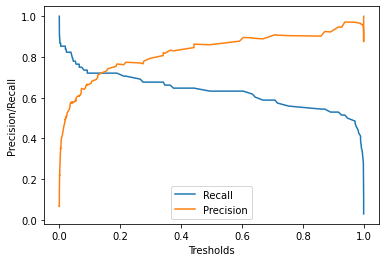

In [27]:
# Presicion / recall curve
precision,recall,tresholds = precision_recall_curve(target_val,predicted)

plt.plot(tresholds,recall[:-1],label="Recall")
plt.plot(tresholds,precision[:-1],label="Precision")
plt.xlabel("Tresholds")
plt.ylabel("Precision/Recall")
plt.legend()
plt.show()

In [31]:
df_val['fraudulent'].value_counts(), sum(predicted >= max_threshold), sum(predicted < max_threshold)

(0    1720
 1      68
 Name: fraudulent, dtype: int64, array([48]), array([1740]))